# Introduction to Vcc Glitch Attacks

Supported setups:

SCOPES:

* OPENADC

PLATFORMS:

* CWLITEARM

In [3]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
sample_size = 5

## Background on Vcc (Power) Glitching

The previous clock glitching tutorials looked into the assumption of a constant clock. But instead we can modify the voltage of the device, causing for example a failure to correctly read a memory location or otherwise cause havoc with the proper functioning.

An example of a successful Vcc glitch is shown in the following figures (Vcc in blue, clock in red):

![](https://wiki.newae.com/images/4/4f/Vccglitch_working.png)

![](https://wiki.newae.com/images/6/60/Vccglitch_working_zoom.png)

Even more so than clock glitching, Vcc glitching is highly sensitive to glitch offset and width. While the above glitch was successful, the following was not:

![](https://wiki.newae.com/images/b/b6/Vccglitch_notworking_zoom.png)

Vcc glitching is also very sensitive to the shape of the glitch: things like board layout and the distance between where the glitch is inserted and the target can make the difference between successful and unsuccessful glitches.

Despite these additional complications, Vcc glitching is an extremely useful tool as it allows attacks on targets that do not run off of external clock inputs.

### Background on Glitch Generation

For more details, please see [Fault_1-Introduction_to_Clock_Glitching](Fault_1-Introduction_to_Clock_Glitch_Attacks.ipynb), this tutorials assumes you have already performed the clock glitching tutorial.

The glitch generation hardware is the same as used in the clock glitching attack. The generated glitches are synchronous to the device clock, and inserted at a precise offset from the clock edge.

Glitches can be inserted continuously or triggered by some event. The following figure shows the generation of two glitches:

![](https://wiki.newae.com/images/9/95/Glitchgen-mux-glitchonly.png)

The VCC glitching method here uses an electronic switch (a MOSFET) to short the power line to GND at specific instances. The following figure shows the basic function of this system:

![](https://wiki.newae.com/images/8/82/Glitch-vccglitcher.png)

This method allows use with the standard side-channel analysis development board, which has resistors inserted into the VCC lines already. The downside of this method is that it can only generate short glitches, since the power consumption through the shunt resistor will short out the resistor.

The MOSFET glitching hardware is built into the ChipWhisperer-Lite (both CW1173 and CW1180) board.

## Setting up Firmware

During this tutorial, we will once again be working off the `glitch-simple` project.

Now navigate to the `glitch-simple` folder and open `glitchsimple.c` in a code editor. Find the `glitch_infinite()` function:

```C
void glitch_infinite(void)
{
    char str[64];
    unsigned int k = 0;
    //Declared volatile to avoid optimizing away loop.
    //This also adds lots of SRAM access
    volatile uint16_t i, j;
    volatile uint32_t cnt;
    while(1){
        cnt = 0;
        trigger_high();
        trigger_low();
        for(i=0; i<200; i++){
            for(j=0; j<200; j++){
                cnt++;
            }
        }
        sprintf(str, "%lu %d %d %d\n", cnt, i, j, k++);
        uart_puts(str);
    }
}
```

As you can see, this function enters into an infinite loop with two inner loops that increment three variables (`cnt`, `i`, and `j`).  These are sent back over serial along with an overall loop counter. During normal operation, we should receive `40000 200 200 $k` (where `$k` is the value of the loop counter `k`). Our objective will be to insert a Vcc glitch such that one or more of the numbers that we get back are incorrect.

Then build the firmware:

In [30]:
%%bash -s "$PLATFORM"
cd ../hardware/victims/firmware/glitch-simple
make PLATFORM=$1 CRYPTO_TARGET=NONE FUNC_SEL=GLITCH_INF

rm -f -- glitchsimple-CWLITEARM.hex
rm -f -- glitchsimple-CWLITEARM.eep
rm -f -- glitchsimple-CWLITEARM.cof
rm -f -- glitchsimple-CWLITEARM.elf
rm -f -- glitchsimple-CWLITEARM.map
rm -f -- glitchsimple-CWLITEARM.sym
rm -f -- glitchsimple-CWLITEARM.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- glitchsimple.s simpleserial.s stm32f3_hal.s stm32f3_hal_lowlevel.s stm32f3_sysmem.s
rm -f -- glitchsimple.d simpleserial.d stm32f3_hal.d stm32f3_hal_lowlevel.d stm32f3_sysmem.d
rm -f -- glitchsimple.i simpleserial.i stm32f3_hal.i stm32f3_hal_lowlevel.i stm32f3_sysmem.i
.
-------- begin --------
arm-none-eabi-gcc (15:5.4.1+svn241155-1) 5.4.1 20160919
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling C: glitchsimple.c
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -DGLITCH_INF -mthumb -mfloat-abi=hard -mfpu=fpv4-sp-d16 -fmessage-length

## Attack Script

### Setup

Now that we've studied the code and have an objective, we can start building our attack script. We'll start by connecting to and setting up the ChipWhisperer, then programming it. As usual, make sure you modify `fw_path` with the path to the file you built in the last step.

In [4]:
%run "Helper_Scripts/Setup_Generic.ipynb"

Serial baud rate = 38400


In [5]:
fw_path = "../hardware/victims/firmware/glitch-simple/glitchsimple-{}.hex".format(PLATFORM)

In [5]:
cw.program_target(scope, prog, fw_path)

Serial baud rate = 115200
Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 7811 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 7811 bytes
Serial baud rate = 38400


Like with clock glitching, Vcc glitching may crash the target, requiring a reset. Like with the previous tutorial, we'll use `reset_target()` from `Helper_Scripts/Setup.ipynb`.

Now that we have some of the basic setup done, let's make sure the firmware works as we expect. If we reset the target and wait a second, then print the serial data we got back, we should see a number of lines of the form `40000 200 200 $k`.

In [6]:
reset_target(scope)
target.flush()
time.sleep(1)
resp = target.read()
print(resp)

40000 200 200 0
40000 200 200 1
40000 200 200 2
40000 200 200 3
40000 200 200 4
40000 200 200 5
40000 200 200 6
40000 200 200 7


### Glitch Setup

First, we'll setup the glitch module itself. Most of these settings should look familiar from the previous tutorial with a few new additions:

* Instead of setting the clock source for the target to be the glitch module, we instead set one of the ChipWhisperer's glitch MOSFETs as our glitch by setting `scope.io.glitch_lp` or `scope.io.glitch_hp` to `True`.
    * Depending on your hardware setup, you may find that one MOSFET works better than the other. If you have trouble glitching the target with one, try the other
* Instead of setting the glitch output to something like "clock_xor", we instead set it to "glitch_only", since we don't want Vcc of the target to be oscillating with our clock.

For the more specific settings (offset, width, repeat, etc), this will depend on both the target and when you got your CW-Lite: Newer versions of the CW-Lite use a different LP glitch MOSFET, which changes the settings required for getting a glitch.

In [7]:
from collections import namedtuple
Range = namedtuple('Range', ['min', 'max', 'step'])
if PLATFORM == "CWLITEARM" or PLATFORM == "CW308_STM32F3":
    scope.glitch.clk_src = "clkgen"
    scope.glitch.output = "glitch_only"
    scope.glitch.trigger_src = "ext_single"
    
    width_range = Range(28, 30, 0.4)
    offset_range = Range(-25, -18, 0.4)
    ext_range = range(1000, 1005)
    
    scope.glitch.width = width_range.min
    scope.glitch.offset = offset_range.min
    scope.glitch.repeat = 1
    glitch_on(scope)
    scope.glitch.ext_offset = 1000
    print(scope.glitch)

clk_src     = clkgen
width       = 28.125
width_fine  = 0
offset      = -25.0
offset_fine = 0
trigger_src = ext_single
arm_timing  = after_scope
ext_offset  = 1000
repeat      = 1
output      = glitch_only



In [8]:
print(scope)

cwlite Device
gain = 
    mode = high
    gain = 30
    db   = 24.8359375
adc = 
    state      = False
    basic_mode = rising_edge
    timeout    = 2
    offset     = 0
    presamples = 0
    samples    = 5000
    decimate   = 1
    trig_count = 1832837399
clock = 
    adc_src       = clkgen_x4
    adc_phase     = 0
    adc_freq      = 29538459
    adc_rate      = 29538459.0
    adc_locked    = True
    freq_ctr      = 0
    freq_ctr_src  = extclk
    clkgen_src    = system
    extclk_freq   = 10000000
    clkgen_mul    = 2
    clkgen_div    = 26
    clkgen_freq   = 7384615.384615385
    clkgen_locked = True
trigger = 
    triggers = tio4
    module   = basic
io = 
    tio1       = serial_rx
    tio2       = serial_tx
    tio3       = high_z
    tio4       = high_z
    pdid       = high_z
    pdic       = high_z
    nrst       = high
    glitch_hp  = False
    glitch_lp  = True
    extclk_src = hs1
    hs2        = clkgen
    target_pwr = True
glitch = 
    clk_src     = clkgen
    w

### Glitching a Single Point

Unlike with the previous tutorial, we don't control when the device sends serial data back to us. This means we'll need to parse the data we get back.

We start our attack off by flushing the ChipWhipserer's serial buffer:

```Python
target.flush()
```

Next, we'll set our trigger source to be "ext_continuous". This differs from "ext_single" in that the ChipWhisperer doesn't need to be armed to insert a glitch, making our loop a little simpler:

```Python
scope.glitch.trigger_src = "ext_continuous"
```

A key part of parsing the serial data is to be able to read a line of data (data terminated with "\n"). We can do that by reading back data until we get a newline character ("\n"):

```Python
while "\n" not in line:
    time.sleep(0.1)
    line += target.read()
```

This needs to be repeated twice in our loop: once at the start to make sure we're on a newline (so we don't look at the wrong numbers for our glitch) and again to actually read the line. For the first read, we also need to make sure we keep any characters after the newline, as this will be the start of the actual line we parse. All together, this looks like:

```Python
line = ""
while "\n" not in line:
    time.sleep(0.1)
    line += target.read()
lines = line.split("\n") 
if len(lines) > 1:
    line = lines[-1]
else:
    line = ""

while "\n" not in line:
    time.sleep(0.1)
    line += target.read(num_char)
```

Now that we have our line of data we can parse it by splitting it up via spaces to get each number. 

After the loop ends, we'll need to set our trigger back to "ext_single" to stop the glitches from continuing.

All together (with some additional error checking), this looks like:

In [14]:
from tqdm import tnrange

scope.io.glitch_hp = False
def glitch_on(scope):
    scope.io.glitch_lp = True
def glitch_off(scope):
    scope.io.glitch_lp = False

scope.glitch.width = 14
scope.glitch.repeat = 63 #EDITED

reset_target(scope)
target.flush()

if SCOPETYPE == "OPENADC":
    scope.glitch.trigger_src = "ext_continuous"

for j in tnrange(20):
    line = ""
    
    while "\n" not in line:
        time.sleep(0.1)
        line += target.read()
        if len(line) < 1: ##ADD
            break ##ADD
    lines = line.split("\n") 
    if len(lines) > 1:
        line = lines[-1]
    else:
        line = ""
    
    while "\n" not in line:
        time.sleep(0.1)
        line += target.read()
        if len(line) < 1: ##ADD
            break ##ADD
        
    if "hello" in line:
        print("Target crashed")
    nums = line.split(" ")
    try:
        if int(nums[0]) != 40000:
            print(line)
        print(line)
    except ValueError as e:
        continue

if SCOPETYPE == "OPENADC":
    scope.glitch.trigger_src = "ext_single"

40000 200 200 2

40000 200 200 4

40000 200 200 6

40000 200 200 9

40000 200 200 11

40000 200 200 13

40000 200 200 15
40
40000 200 200 18

40000 200 200 20

40000 200 200 22

40000 200 200 24
40000 200 200 25

40000 200 200 27

40000 200 200 29

40000 200 200 31

40000 200 200 33
40000 200 200 34

40000 200 200 36

40000 200 200 38

40000 200 200 40

40000 200 200 42
40000 200 200 43

40000 200 200 45




You should hopefully see some glitched lines printed after running the above block. If not, don't worry -- we'll be adjusting the settings of the glitch which should make them more likely.

### Improving Glitch Settings

One more thing we can do to improve our glitch success rate is to modify our glitch settings (width and offset) while holding the ext offset constant. 

Similar to [Fault_1](Fault_1-Introduction_to_Clock_Glitch_Attacks.ipynb), let's also measure our success rate with each glitch setting, as well as our crash rate, then print them at the end.

To keep things a little more sane, let's put our glitch attempt into a function:

In [15]:
def do_glitch():
    global scope, target
    line = ""
    while "\n" not in line:
        time.sleep(0.1)
        num_char = target.in_waiting()
        if num_char == 0:
            glitch_off(scope)
            time.sleep(0.01)
            glitch_on(scope)
            break
        line += target.read()
    lines = line.split("\n") 
    if len(lines) > 1:
        line = lines[-1]
    else:
        line = ""

    while "\n" not in line:
        time.sleep(0.1)
        num_char = target.in_waiting()
        if num_char == 0:
            glitch_off(scope)
            time.sleep(0.01)
            glitch_on(scope)
            break
        line += target.read()

    nums = line.split(" ")
    crashes=0
    if "hello" in line:
        crashes = 1
    successes = 0
    try:
        if nums[0] == "":
            pass
        if int(nums[0]) != 40000:
            successes = 1
    except ValueError as e:
        pass
    return successes, crashes

Then we can run the actual loop that iterates through all our settings:

In [34]:
from tqdm import tnrange, tqdm_notebook

reset_target(scope)
glitches = []
glitch_text = []

target.flush()
scope.glitch.trigger_src = "ext_continuous"
scope.glitch.offset_fine = 0

width_range = Range(28, 35, 0.5) #<-- TUNE THIS FOR YOUR BOARD
offset_range = Range(-35, -15, 0.5) #Expand
ext_range = range(1002, 1003) #Fixed to speed up
scope.glitch.width = width_range.min
scope.glitch.offset = offset_range.min
scope.glitch.repeat = 25 #<-- TUNE THIS FOR YOUR BOARD
sample_size = 2 #<-- Set to speed up capture (test N times at each setting)

##BOOM - Added the following TWO LINES
import chipwhisperer.common.results.glitch as glitch
gr = glitch.GlitchResults(groups=["success", "reset", "normal"], parameters=["width", "offset"])
#gr.add("success", (scope.glitch.width, scope.glitch.offset))

t_offset = tqdm_notebook(total=int((offset_range.max-offset_range.min)/offset_range.step) + 1, leave=False,desc="Offset")
while scope.glitch.offset < offset_range.max:
    scope.glitch.width = width_range.min
    t_width = tqdm_notebook(total=int((width_range.max-width_range.min)/width_range.step), leave=False, desc="Width")
    while scope.glitch.width < width_range.max:
        for j in tqdm_notebook(ext_range, leave=False, desc="Ext range"):
            scope.glitch.ext_offset = j
            successes = 0
            crashes = 0
            for k in tnrange(sample_size, leave=False, desc="Attempt"):
                ret = do_glitch()
                successes += ret[0]
                crashes += ret[1]
                #ADD THESE LINES BELOW:
                if ret[0]:
                    gr.add("success", (scope.glitch.width, scope.glitch.offset))
                if ret[1]:
                    gr.add("reset", (scope.glitch.width, scope.glitch.offset))
                if ret[0] == ret[1] == 0:
                    gr.add("normal", (scope.glitch.width, scope.glitch.offset))
                  
        glitches.append([scope.glitch.width, scope.glitch.offset, successes/sample_size, crashes/sample_size, j])
        if successes > 0:
            print([scope.glitch.width, scope.glitch.offset, successes/sample_size, crashes/sample_size, j])
        scope.glitch.width += width_range.step
        t_width.update()

    scope.glitch.offset += offset_range.step
    t_offset.update()
    t_width.close()
t_width.close()
t_offset.close()
scope.glitch.trigger_src = "ext_single"


[32.03125, -34.375, 0.5, 0.0, 1002]


[32.421875, -34.375, 0.5, 0.0, 1002]


[32.421875, -33.984375, 1.0, 0.0, 1002]


[32.421875, -33.203125, 0.5, 0.0, 1002]


[32.8125, -33.203125, 0.5, 0.0, 1002]


[32.8125, -32.8125, 1.0, 0.0, 1002]


[32.8125, -31.640625, 1.0, 0.0, 1002]


[33.203125, -31.640625, 0.5, 0.0, 1002]


[32.8125, -31.25, 0.5, 0.0, 1002]


[33.203125, -31.25, 0.5, 0.0, 1002]


[33.203125, -30.46875, 0.5, 0.0, 1002]


[33.203125, -30.078125, 0.5, 0.0, 1002]


[33.59375, -30.078125, 1.0, 0.0, 1002]


[33.59375, -28.515625, 0.5, 0.0, 1002]


[33.984375, -28.515625, 1.0, 0.0, 1002]


[33.984375, -27.34375, 0.5, 0.0, 1002]


[33.984375, -26.953125, 0.5, 1.0, 1002]


[28.125, -15.625, 0.5, 0.0, 1002]


<IPython.core.display.Javascript object>


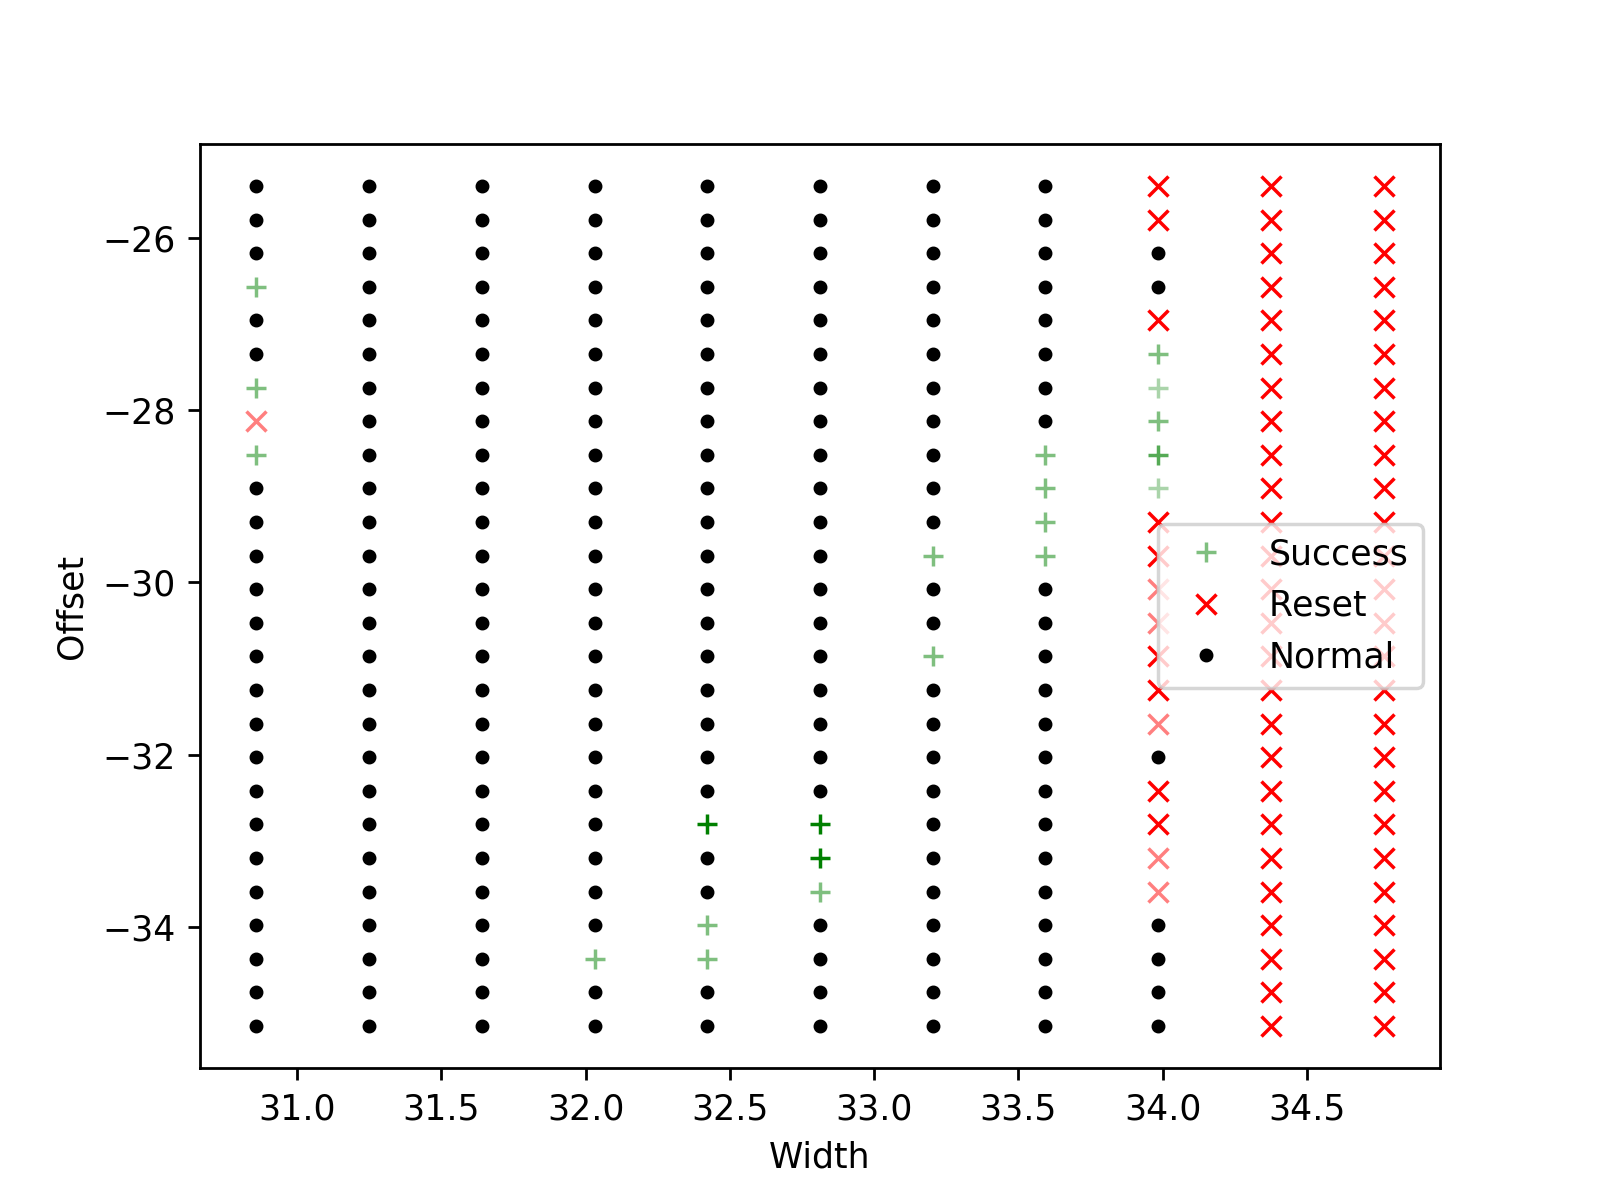

In [33]:
%matplotlib notebook
import matplotlib.pylab as plt
gr.plot_2d(plotdots={"success":"+g", "reset":"xr", "normal":".k"})

Then, sorting by success rate:

In [39]:
def sort_glitch(glitch):
    return glitch[2]

glitches.sort(key=sort_glitch,reverse=True)

import pandas as pd
df = pd.DataFrame(glitches, columns=["Width","Offset","Success Rate", "Reset Rate", "ext_offset"])
display(df)

,Width,Offset,Success Rate,Reset Rate,ext_offset
0,32.421875,-33.984375,1.0,0.0,1002
1,32.812500,-32.812500,1.0,0.0,1002
2,32.812500,-31.640625,1.0,0.0,1002
3,33.593750,-30.078125,1.0,0.0,1002
4,33.984375,-28.515625,1.0,0.0,1002
5,32.031250,-34.375000,0.5,0.0,1002
6,32.421875,-34.375000,0.5,0.0,1002
7,32.421875,-33.203125,0.5,0.0,1002
8,32.812500,-33.203125,0.5,0.0,1002
9,33.203125,-31.640625,0.5,0.0,1002


### Going Further

There's a lot more you can do with this attack:

* If you still weren't able to get any glitches, create an attack loop that scans a larger range of offsets and ranges.
    * We also used a repeat of 1. You may find more success using a large repeat and a smaller width.
* Glitching different instructions will produce different results. Try using your best glitch settings from the previous part and scanning ext offset ranges to produce different glitches
    * During our attack loop, we only checked for glitches in the first number (40000). You may want to examine the other numbers for glitches as well
    * Open the listing file (`.lss`) and view the assembly of the `glitch_infinite()` function. Can you explain the different glitch effects you saw?
* Try using the glitch settings you found in this tutorial to glitch other functions in the `glitchsimple.c` file.

Otherwise, we're done with the tutorial. You can now disconnect from the ChipWhisperer:

In [ ]:
scope.dis()
target.dis()

## Conclusion

With the tutorial now finished, you should have some Vcc glitching experience under your belt. If you're interested in doing more Vcc glitching, you may want to try [Tutorial A9](https://wiki.newae.com/Tutorial_A9_Bypassing_LPC1114_Read_Protect) from the ChipWhisperer Wiki, which uses Vcc glitching to bypass code readout protection on an LPC1114 (requires an LPC1114 dev board). You may also want to try glitching some of the other functions in `glitchsimple.c`. If you have a Raspberry Pi, you can also attempt the attack described [here](https://wiki.newae.com/Tutorial_A3_VCC_Glitch_Attacks#Glitching_More_Advanced_Targets:_Raspberry_Pi) (though you'll need to transfer the steps from the old GUI over to Jupyter).

## Tests

In [ ]:
# Test we got at least one success
# Should be sorted by success rate, so just check first one
success = glitches[0][2] > 0
assert success, "Failed to glitch target"